In [17]:
import pandas as pd
import yfinance as yf
import os
from dotenv import load_dotenv
import fredapi
from fredapi import Fred
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

In [31]:
housing_index = fred.get_series('CSUSHPISA')
housing_index = housing_index.dropna()
housing_index.head()

1987-01-01    63.962
1987-02-01    64.422
1987-03-01    64.733
1987-04-01    65.129
1987-05-01    65.563
dtype: float64

<AxesSubplot:title={'center':'Case-Shiller National Home Price Index Historical'}, xlabel='Date', ylabel='Index'>

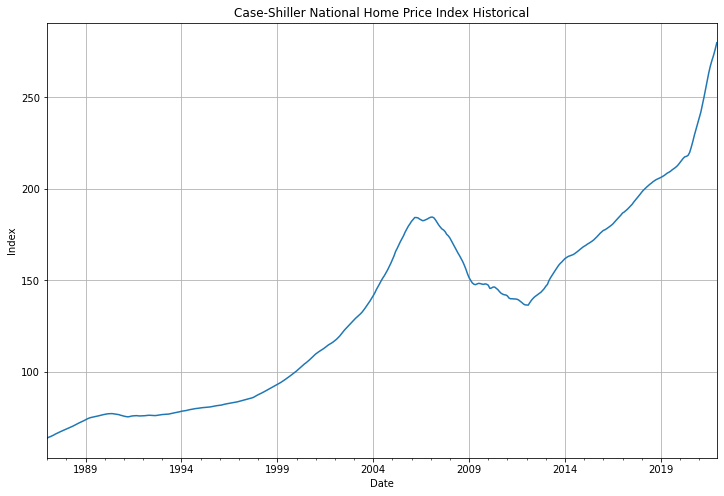

In [20]:
housing_index.plot(figsize=(12,8), title='Case-Shiller National Home Price Index Historical', grid=True, xlabel='Date', ylabel='Index')

In [21]:
# Pull S&P 500 historical data
ticker = "^GSPC" 
start= "1990-01-01" 
end= "2021-12-31"

sp_history = yf.download(ticker, start=start, end=end, progress=False)
sp_history = sp_history.asfreq(freq='D').ffill().dropna()
sp_history.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000.0
1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000.0
1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000.0
1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000.0
1990-01-06,355.670013,355.670013,351.350006,352.200012,352.200012,158530000.0


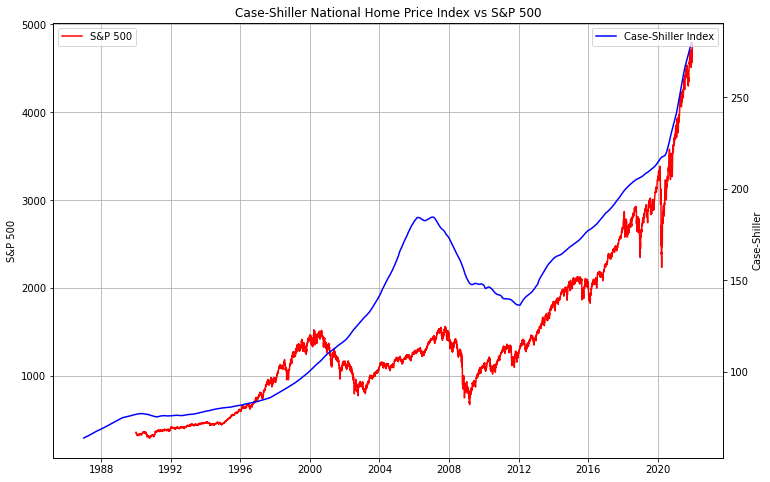

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(sp_history['Adj Close'], label ='S&P 500', color='r')
ax.set_ylabel('S&P 500')
plt.grid()
ax.legend(loc='upper left')

ax2 = ax.twinx()
plt.plot(housing_index, label='Case-Shiller Index', color='b')
ax.set_title('Case-Shiller National Home Price Index vs S&P 500')
ax2.set_ylabel('Case-Shiller')
ax2.legend(loc='upper right')

In [23]:
# Pull Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi = fred.get_series('CPIAUCSL', observation_start='2018-01-01')
cpi.tail()

2021-09-01    274.214
2021-10-01    276.590
2021-11-01    278.524
2021-12-01    280.126
2022-01-01    281.933
dtype: float64

In [24]:
cpi_percent_change = cpi.pct_change().dropna()
cpi_percent_change.tail()

2021-09-01    0.004109
2021-10-01    0.008665
2021-11-01    0.006992
2021-12-01    0.005752
2022-01-01    0.006451
dtype: float64

In [75]:
# Concat Housing Index and CPI data, monthly freq
combined = pd.concat([housing_index, cpi, cpi_percent_change], axis=1).dropna()
combined['house_index'] = combined[0] * 1000 # convert to dollar value 
combined['cpi'] = combined[1]
combined['cpi_pct_chg'] = combined[2]
combined = combined.drop([combined.columns[0], combined.columns[1], combined.columns[2]], axis=1)
combined = combined['2018-01-01':].round(3)
combined.head()

,house_index,cpi,cpi_pct_chg
2018-02-01,199192.0,249.439,0.003
2018-03-01,200064.0,249.581,0.001
2018-04-01,200879.0,250.146,0.002
2018-05-01,201657.0,250.779,0.003
2018-06-01,202424.0,251.118,0.001


In [70]:
# Set reference CPI cost for comparison
ref_cpi_cost = cpi['2018-01-01'] 
ref_cpi_cost

248.743

In [82]:
# Adjust Case-Schiller Index for inflation
combined['house_index_inf_adj'] = (combined['house_index'] / combined['cpi']) * ref_cpi_cost
combined.tail()

,house_index,cpi,cpi_pct_chg,house_Ind_inf_adj,house_ind_inf_adj,house_index_inf_adj
2021-08-01,267183.0,273.092,0.003,243360.848978,243360.848978,243360.848978
2021-09-01,270225.0,274.214,0.004,245124.527468,245124.527468,245124.527468
2021-10-01,272976.0,276.590,0.009,245492.856459,245492.856459,245492.856459
2021-11-01,276189.0,278.524,0.007,246657.668377,246657.668377,246657.668377
2021-12-01,279801.0,280.126,0.006,248454.410312,248454.410312,248454.410312


<AxesSubplot:title={'center':'Case-Schiller Index Inflation Adjusted - period 01-01-2018 - 12-01-2021 (reference CPI 01-01-2018)'}, xlabel='Date', ylabel='Case-Schiller'>

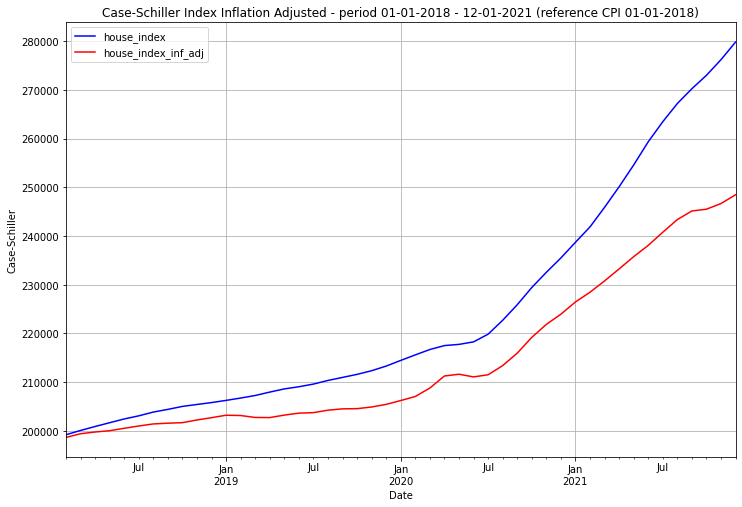

In [83]:
# Plot increase in housing prices for the specified time period
combined[['house_index', 'house_index_inf_adj']].plot(figsize=(12,8), title='Case-Schiller Index Inflation Adjusted - period 01-01-2018 - 12-01-2021 (reference CPI 01-01-2018)', grid=True, ylabel='Case-Schiller', xlabel='Date',color=('b','r'))